# PCNA experiments raw data viewer

This notebook takes the output of the 4-channel brightfield, gfp-h2b, rfp-h2b, irfp-pcna experiments, formats the images into stacks and displays the stacks in Napari.

In [66]:
import napari
print("Napari version no.:", napari.__version__)
import btrack
print('Btrack version', btrack.__version__)
import os, glob, enum
import numpy as np
import tifffile as tiff
from tqdm import tqdm
from skimage.io import imread
from natsort import natsorted
from datetime import datetime
from btrack.utils import tracks_to_napari

Napari version no.: 0.4.10
Btrack version 0.4.2


### Set data folder and number of channels to display

In [25]:
### set root data folder
root_folder = '/home/nathan/data/confocal/pcna'
#expt_IDs = natsorted([ID for ID in os.listdir(root_folder) if 'MK' in ID])
#print('Experiment/position list:', [(expt,natsorted([pos for pos in os.listdir(os.path.join(root_folder, expt)) if 'Pos' in pos])) for expt in expt_IDs])
print(natsorted([pos for pos in os.listdir(root_folder) if 'Pos' in pos]))
### not entirely sure this is the correct use of a class but im still learning
@enum.unique
class channels(enum.Enum):
    bf = 3 
    gfp = 1
    #rfp = 2
    irfp = 2
    cp_masks = 4

['Position1', 'Position2', 'Position3', 'Position4', 'Position5']


Select one position

In [75]:
#expt = 'MK0000'
pos = 'Position2'#'Pos15'

#data_folder = os.path.join(root_folder, '{}/{}'.format(expt, pos)) #'/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15'#'/media/nathan/Transcend/Nathan/data/pcna/test_210422/Pos7'
data_folder = os.path.join(root_folder, '{}'.format(pos)) #'/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15'#'/media/nathan/Transcend/Nathan/data/pcna/test_210422/Pos7'

### Compile folders of single frame images into stacks if necessary

In [56]:
## compile stacks
output_dir = os.path.join(data_folder,'{}_stacks'.format(pos))
if '{}_stacks'.format(pos) not in os.listdir(data_folder):
    os.mkdir(os.path.join(data_folder,'{}_stacks'.format(pos)))
    print(output_dir, 'directory created')
    for channel in channels:
        print(channel.name, 'compiling')
        files = glob.glob(os.path.join(data_folder, '{}_raw'.format(pos),'img_channel00{}*.tif'.format(channel.value)))
        stack = []
        for file in tqdm(natsorted(files)):
            tif = np.array(tiff.imread(file),dtype=np.uint8)
            tif_w,tif_h = np.shape(tif)[0],np.shape(tif)[1]
            tif = tif[int((tif_w-1200)/2):int(tif_w-(tif_w-1200)/2),int((tif_h-1600)/2):int(tif_h-(tif_h-1600)/2)] ## cropping
            stack.append(tif)
        stack = np.stack(stack,axis=0)
        with tiff.TiffWriter(os.path.join(output_dir,'{}.tif'.format(channel.name)),imagej=True) as output_file:
            output_file.save(stack)
        print(channel.name, 'saved out')
else:
    print('looks like stacks already exist bro')

/home/nathan/data/confocal/pcna/Position2/Position2_stacks directory created
cp_masks compiling


100%|████████████████████████████████████████| 150/150 [00:00<00:00, 202.41it/s]

cp_masks saved out


### Load images 

In [68]:
data_folder

'/home/nathan/data/confocal/pcna/Position5'

from confocal data sets

In [76]:
### load images confocal
output_dir = os.path.join(data_folder)#,'{}_stacks'.format(pos))
stack_fn = {}
for channel in channels:
    stack_fn[channel.name] = glob.glob(os.path.join(output_dir, 'Chan{}*.tif'.format(channel.value)))
    #stack_fn[channel.name] = glob.glob(os.path.join(output_dir, '{}.tif'.format(channel.name)))
gfp = imread(stack_fn['gfp'][0])
#bf = imread(stack_fn['bf'][0])
irfp = imread(stack_fn['irfp'][0])
#masks = imread(stack_fn['cp_masks'][0])

In [57]:
masks = imread(stack_fn['cp_masks'][0])

In [58]:
masks.shape

(150, 512, 512)

from kraken data sets

In [ ]:
### load images kraken
output_dir = os.path.join(data_folder)#,'{}_stacks'.format(pos))
stack_fn = {}
for channel in channels:
    stack_fn[channel.name] = glob.glob(os.path.join(output_dir, 'channel00{}.tif'.format(channel.value)))
    #stack_fn[channel.name] = glob.glob(os.path.join(output_dir, '{}.tif'.format(channel.name)))
# gfp = imread(stack_fn['gfp'][0])
# rfp = imread(stack_fn['rfp'][0])
irfp = imread(stack_fn['irfp'][0])

### Load tracks

In [89]:
tracking_fn = [fn for fn in glob.glob(data_folder+'/*.h5')][1]

In [90]:
tracking_fn

'/home/nathan/data/confocal/pcna/Position2/irfp_tracks_2021_08_09_05_47_39_PM.h5'

In [91]:
with btrack.dataio.HDF5FileHandler(tracking_fn, 'r', obj_type = "obj_type_1") as hdf:
    tracks_ = hdf.tracks
tracks, properties, graph = tracks_to_napari(tracks_, ndim = 2)

[INFO][2021/08/09 05:49:43 pm] Opening HDF file: /home/nathan/data/confocal/pcna/Position2/irfp_tracks_2021_08_09_05_47_39_PM.h5...


2021-08-09 17:49:43,282 [INFO] Opening HDF file: /home/nathan/data/confocal/pcna/Position2/irfp_tracks_2021_08_09_05_47_39_PM.h5...


[INFO][2021/08/09 05:49:43 pm] Loading tracks/obj_type_1


2021-08-09 17:49:43,288 [INFO] Loading tracks/obj_type_1


[INFO][2021/08/09 05:49:43 pm] Loading objects/obj_type_1 (10421, 5) (10421 filtered: None)


2021-08-09 17:49:43,308 [INFO] Loading objects/obj_type_1 (10421, 5) (10421 filtered: None)


[INFO][2021/08/09 05:49:43 pm] Closing HDF file: /home/nathan/data/confocal/pcna/Position2/irfp_tracks_2021_08_09_05_47_39_PM.h5


2021-08-09 17:49:43,471 [INFO] Closing HDF file: /home/nathan/data/confocal/pcna/Position2/irfp_tracks_2021_08_09_05_47_39_PM.h5


In [85]:
[cell for cell in tracks_ if cell.ID == 2][0]

OrderedDict([('ID', 2), ('t', [0, 1, 2]), ('x', [509.0843505859375, 509.73077392578125, 510.10809326171875]), ('y', [368.9638671875, 366.0384521484375, 363.4053955078125]), ('z', [0.0, 0.0, 0.0]), ('parent', 2), ('root', 2), ('state', [5, 5, 5]), ('generation', 0), ('dummy', [False, False, False]), ('area', array([83., 52., 37.], dtype=float32)), ('major_axis_length', array([19.107662, 16.17192 , 14.840251], dtype=float32))])

2021-08-09 16:43:03,038 [INFO] WRITING LOG OUTPUT TO /home/nathan/.cellpose/run.log


/home/nathan/anaconda3/envs/cell-comp-analysis/lib/python3.9/site-packages/napari/plugins/_plugin_manager.py:366: UserWarning: Plugin 'cellpose-napari' has already registered a dock widget 'cellpose' which has now been overwritten
  warn(message=warn_message)


### Load many tracks

In [27]:
tracks_path = natsorted(glob.glob('/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/{}/{}/*.h5'.format(expt, pos)))
[(i, name) for i,name in enumerate(tracks_path)]

[(0,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/_irfp_tracks.h5'),
 (1,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_21_05_57_38_PM.h5'),
 (2,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5'),
 (3,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5'),
 (4,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_21_05_57_45_PM.h5'),
 (5,
  '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5')]

In [28]:
gfp_tracks = tracks_path[2]
rfp_tracks = tracks_path[5]
irfp_tracks = tracks_path[3]

with btrack.dataio.HDF5FileHandler(irfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
    wt2_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(gfp_tracks, 'r', obj_type = "obj_type_3") as hdf:
    wt_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(rfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
    scr_tracks = hdf.tracks
print("Tracks loaded")

[INFO][2021/05/30 06:53:39 pm] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5...


2021-05-30 18:53:39,114 [INFO] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5...


[INFO][2021/05/30 06:53:39 pm] Loading tracks/obj_type_2


2021-05-30 18:53:39,163 [INFO] Loading tracks/obj_type_2


[INFO][2021/05/30 06:53:39 pm] Loading objects/obj_type_2 (551730, 5) (551730 filtered: None)


2021-05-30 18:53:39,685 [INFO] Loading objects/obj_type_2 (551730, 5) (551730 filtered: None)


[INFO][2021/05/30 06:53:46 pm] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5


2021-05-30 18:53:46,355 [INFO] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/irfp_tracks_2021_05_28_07_16_36_PM.h5


[INFO][2021/05/30 06:53:46 pm] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5...


2021-05-30 18:53:46,359 [INFO] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5...


[INFO][2021/05/30 06:53:46 pm] Loading tracks/obj_type_3


2021-05-30 18:53:46,417 [INFO] Loading tracks/obj_type_3


[INFO][2021/05/30 06:53:47 pm] Loading objects/obj_type_3 (551730, 5) (551730 filtered: None)


2021-05-30 18:53:47,028 [INFO] Loading objects/obj_type_3 (551730, 5) (551730 filtered: None)


[INFO][2021/05/30 06:53:52 pm] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5


2021-05-30 18:53:52,517 [INFO] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_28_07_20_04_PM.h5


[INFO][2021/05/30 06:53:52 pm] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5...


2021-05-30 18:53:52,520 [INFO] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5...


[INFO][2021/05/30 06:53:52 pm] Loading tracks/obj_type_2


2021-05-30 18:53:52,568 [INFO] Loading tracks/obj_type_2


[INFO][2021/05/30 06:53:52 pm] Loading objects/obj_type_2 (10306, 5) (10306 filtered: None)


2021-05-30 18:53:52,646 [INFO] Loading objects/obj_type_2 (10306, 5) (10306 filtered: None)


[INFO][2021/05/30 06:53:52 pm] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5


2021-05-30 18:53:52,749 [INFO] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/rfp_tracks_2021_05_28_07_20_11_PM.h5
Tracks loaded


### Inspect tracks

In [82]:
[cell for cell in tracks_ if cell.ID ==2][0]

OrderedDict([('ID', 2), ('t', [0, 1, 2]), ('x', [509.0843505859375, 509.73077392578125, 510.10809326171875]), ('y', [368.9638671875, 366.0384521484375, 363.4053955078125]), ('z', [0.0, 0.0, 0.0]), ('parent', 2), ('root', 2), ('state', [5, 5, 5]), ('generation', 0), ('dummy', [False, False, False]), ('area', array([83., 52., 37.], dtype=float32)), ('major_axis_length', array([19.107662, 16.17192 , 14.840251], dtype=float32))])

In [11]:
len(tracks)

14733

In [54]:
masks.shape

(150, 344, 512)

### Launch napari

In [92]:
### launch napari
#with napari.gui_qt():
viewer = napari.Viewer()
    
### add imagesirfp_tracks[0]
#viewer.add_image(bf, name = "brightfield")
viewer.add_image(gfp, name="gfp", blending = "additive", colormap = "green")
#viewer.add_image(rfp, name="rfp", contrast_limits = (0, 50), blending = "additive", colormap = "magenta")
viewer.add_image(irfp, name="irfp", blending = "additive", colormap = "cyan")
#viewer.add_image(masks, name="masks", blending = "additive", colormap = "magenta")

## add tracks
viewer.add_tracks(tracks)
#viewer.add_tracks(irfp_tracks)
#viewer.add_tracks(scr_tracks)
napari.run()

/home/nathan/anaconda3/envs/cell-comp-analysis/lib/python3.9/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


# printing tracks

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

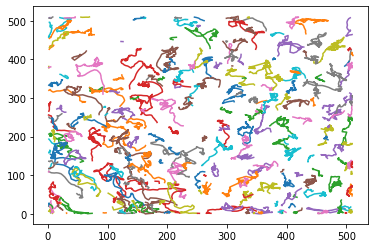

In [14]:
for i in range(len(tracks)):
    plt.plot(tracks[i].x, tracks[i].y)

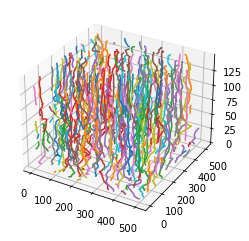

<Figure size 720x720 with 0 Axes>

In [30]:
ax = plt.axes(projection='3d')
plt.figure(figsize=(10,10))
for i in range(len(tracks)):
    ax.plot3D(tracks[i].x, tracks[i].y, tracks[i].t)